# Heavy rainfall


```{glue:figure} number_wet_days
:scale: 60%
:align: center
```

```{glue:figure} number_over_95
:scale: 60%
:align: center
```

**Figure. Annual wet days (top) and days with heavy rainfall (bottom) over the period 1951–2024 at Koror.**  Wet days are defined as days above 1mm (0.04 inches).  Heavy rainfall days are defined as days where rainfall is greater than 45.7mm (1.98 inches), the 95th percentile.    The solid black lines represent statistically significant trends (p < 0.05).  The dashed black line represents a trend that is not statistically significant.

## Setup

First, we need to import all the necessary libraries. Some of them are specifically developed to handle the download and plotting of the data and are hosted at the [indicators set-up repository](https://github.com/lauracagigal/indicators_setup) in GitHub

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os.path as op
import sys

from myst_nb import glue 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting import plot_bar_probs
from ind_setup.colors import get_df_col
from ind_setup.core import fontsize

sys.path.append("../../../functions")
from data_downloaders import GHCN, filter_by_time_completeness


In [2]:
country = 'Palau'
vars_interest = ['PRCP']

### Get Data

In [3]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

In [4]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

### Obervations from Koror Station

https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf

The data used for this analysis comes from the GHCN (Global Historical Climatology Network)-Daily database. <br>
This a database that addresses the critical need for historical daily temperature, precipitation, and snow records over global land areas. GHCN-Daily is a
composite of climate records from numerous sources that were merged and then subjected to a suite of
quality assurance reviews. The archive includes over 40 meteorological elements including temperature daily maximum/minimum, temperature at observation time,
precipitation and more.

In [5]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_prcp = GHCN.extract_dict_data_var(GHCND_dir, 'PRCP', df_country_stations.loc[df_country_stations['ID'] == id])[0]
    data = dict_prcp[0]['data']#.dropna()
    data.to_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))
else:
    data = pd.read_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))

In [6]:
df_filt, removed_months, removed_years = filter_by_time_completeness(
    data,
    month_threshold=0.75,
    year_threshold=0.75
)
print(f"Removed {removed_months.shape[0]} months due to insufficient data: {removed_months.index.tolist()}")
print(f"Removed {removed_years.shape[0]} years due to insufficient data: {removed_years.index.tolist()}")

data = df_filt #replace data with filtered data
data_daily = data.copy()

Removed 9 months due to insufficient data: [(2018, 8), (2019, 1), (2022, 7), (2022, 11), (2022, 12), (2023, 1), (2023, 8), (2024, 2), (2025, 10)]
Removed 1 years due to insufficient data: [2019]


#### Wet days

Now we are going to classify every day as a wet or dry day. <br>
Wet days are considered when rainfall is above 1mm

In [7]:
data = data.groupby(data.index.year).filter(lambda x: len(x) >= 300).dropna()

glue("n_years", len(np.unique(data.index.year)), display=False)


In [8]:
data['wet_day'] = np.where(data['PRCP'] >= 1, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))

Text(0, 0.5, 'Number of Days')

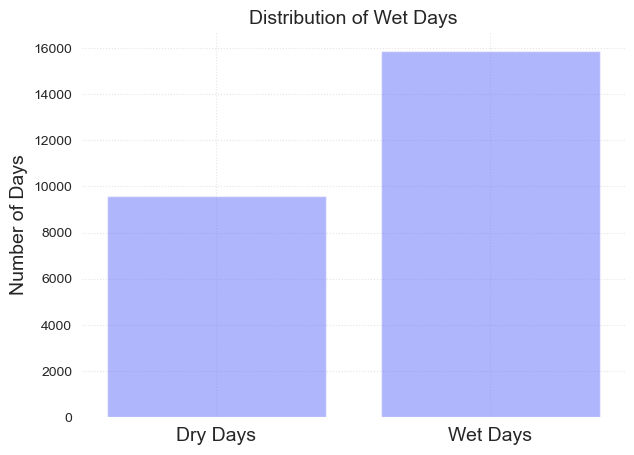

In [9]:
fig, ax = plot_bar_probs(x = [0, 1], y = data.groupby('wet_day').count()['PRCP'].values, labels = ['Dry Days', 'Wet Days'])
ax.set_title('Distribution of Wet Days', fontsize = fontsize)
ax.set_ylabel('Number of Days', fontsize = fontsize)    

#### Number of days over and above 1mm threshold

The following plot analyzes the number of wet (over 1mm) and dry days over time

In [10]:
threshold = 1 #np.percentile(data['PRCP'].dropna(), 90)
data['wet_day_t'] = np.where(data['PRCP'] > threshold, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))
data_th_1mm = data.copy()

In [11]:
data_th = data.groupby([data.index.year, data.wet_day_t]).count()['PRCP']
data_th = data_th/data.groupby(data.index.year).count()['PRCP'] * 365

Text(0, 0.5, 'Number of days')

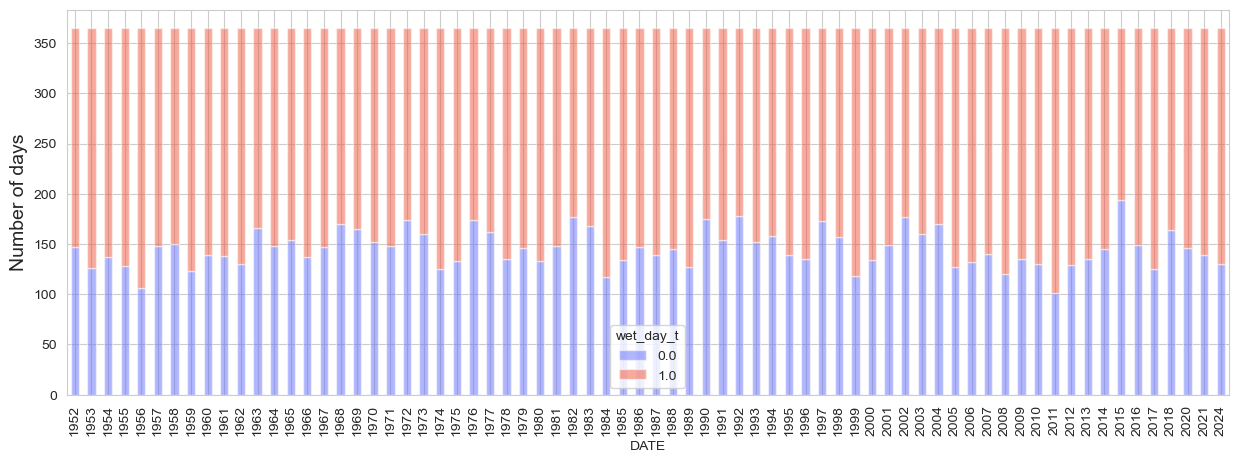

In [12]:
fig, ax = plt.subplots(figsize = [15, 5])
data_th.unstack().plot(kind = 'bar', stacked = True, ax = ax, color = get_df_col()[:2], edgecolor = 'white', alpha = .5)
ax.set_ylabel('Number of days', fontsize = fontsize)

The following plots analyze independently the number of wet and dry days over time as well the trend over time which is not significant in both cases.

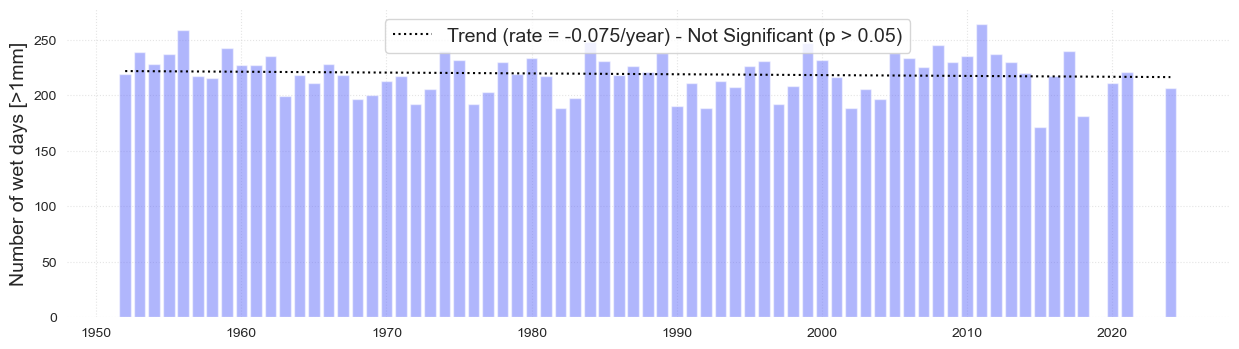

In [13]:
#Wet days
data2 = data.loc[data['wet_day_t'] == 1]
data2 = data2.groupby(data2.index.year).count()
fig, ax, trend_wet = plot_bar_probs(x = data2.index, y = data2.PRCP.values, trendline = True,
               y_label = 'Number of wet days [>1mm]', figsize = [15, 4], return_trend = True)
plt.savefig(op.join(path_figs, 'F7a_Wet_days_1mm.png'), dpi=300, bbox_inches='tight')
glue("number_wet_days", fig, display=False)

glue("trend_wet", float(trend_wet), display=False)


## Analysis

### Days over 95 threshold

To have a metric of the changes in the extreme rainfall regime, the number of days over the 95 percentile is analyzed in the following plot

In [14]:
prcentile = 95
data = data.drop('wet_day', axis = 1)
threshold = np.round(np.percentile(data['PRCP'].dropna(), prcentile), 2)
print(f'Threshold of {threshold}mm')
data['wet_day_t'] = np.where(data['PRCP'] > threshold, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))
data_th_95 = data.copy()

Threshold of 45.2mm


In [15]:
data_2 = data.loc[data['wet_day_t'] == 1][['PRCP']]
data_over_th = data_2.groupby(data_2.index.year).count()
data_over_th.index = pd.to_datetime(data_over_th.index, format = '%Y')


In [16]:
data_over_th['PRCP_below'] = 365 - data_over_th['PRCP'].values

In [17]:
dict_plot = [{'data' : data_over_th, 'var' : 'PRCP', 'ax' : 1, 'label':f'Number of days over threshold: {threshold}mm'},]

In [18]:
data_over_th

,PRCP,PRCP_below
DATE,,
1952-01-01,25,340
1953-01-01,19,346
1954-01-01,20,345
1955-01-01,9,356
1956-01-01,23,342
...,...,...
2017-01-01,22,343
2018-01-01,13,352
2020-01-01,17,348


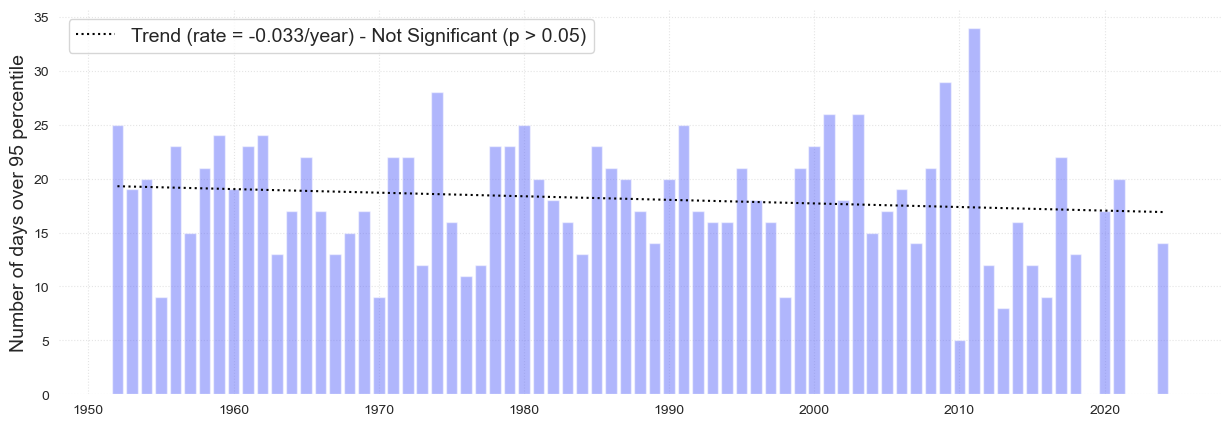

In [19]:
fig, ax, trend_95 = plot_bar_probs(x = data_over_th.index.year, y = data_over_th['PRCP'].values, trendline = True,
               figsize = (15, 5), return_trend = True, y_label = f'Number of days over {prcentile} percentile')

plt.savefig(op.join(path_figs, 'F7b_Wet_days_95p.png'), dpi=300, bbox_inches='tight')
glue('number_over_95', fig, display=False)

### Table
Table sumarizing different metrics of the data analyzed in the plots above

In [20]:
from ind_setup.tables import style_matrix, table_rain_23

In [21]:
style_matrix(table_rain_23(data_th_1mm, data_th_95, trend_wet, trend_95))

Metric,Value
Annual average of wet days,218.986
Change in number of wet days from 1951,-5.475
Rate of change in number of wet days,-0.075
Average Number of Wet Days: 1951 - 1962,240.091
Average Number of Wet Days: 2012 - 2021,222.222
Wet days in the wettest year: 2011,269.000
,
Annual average number of days with heavy rainfall (>95th percentile),18.143
Maximum number of days with heavy rainfall (>95th percentile): 2011,34.000
Minimum number of days with heavy rainfall (>95th percentile): 2010,5.000
